In [1]:
# Import necessary libraries
import torch
from datasets import load_dataset
from src.integrated_hessians import integrated_hessians
from src.model_utils import load_model_and_tokenizer
from src.integrated_gradients import integrated_gradients
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/root/projects/integrated_gradients/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer, model = load_model_and_tokenizer(model_name)

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [3]:
# Load example text
text = "This movie was not bad"

# Tokenize input and baseline (all zeros => [PAD] token)
tokens = tokenizer(text, return_tensors='pt', padding='max_length', max_length=128, truncation=True).to(device)
input_ids = tokens['input_ids']
pad_id = tokenizer.pad_token_id
baseline_ids = torch.full_like(input_ids, pad_id).to(device)

In [4]:
hessians = integrated_hessians(model, input_ids, baseline_ids, steps=10, target_class=1)

decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

valid_length = (input_ids[0] != pad_id).sum().item()
decoded_tokens = decoded_tokens[:valid_length]


/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
Processing alphas: 100%|██████████| 10/10 [01:22<00:00,  8.20s/step]


['This', 'Ġmovie', 'Ġwas', 'Ġnot', 'Ġbad']
torch.Size([127, 127])


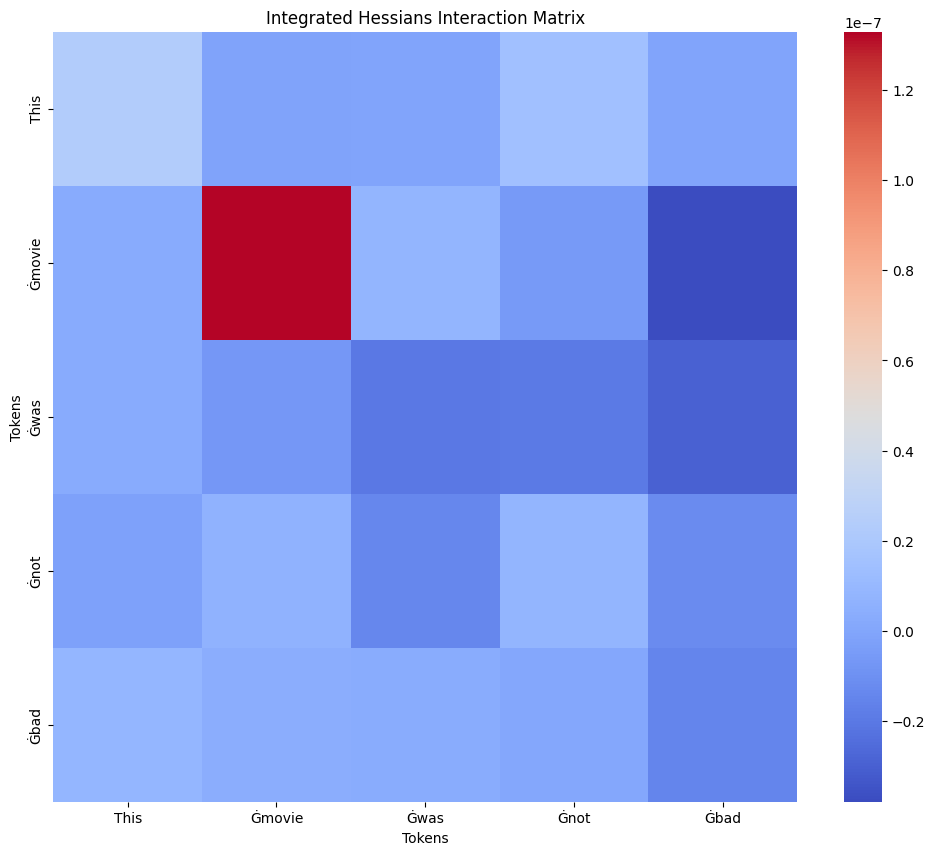

Most important tokens: This Ġnot


In [5]:

def visualize_hessians(hessians, tokens):
    print(tokens)

    print(hessians.shape)    
    hessians = hessians[:len(tokens), :len(tokens)]
    hessians = hessians.detach().cpu().numpy()

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(hessians, xticklabels=tokens, yticklabels=tokens, cmap="coolwarm", annot=False)
    plt.title("Integrated Hessians Interaction Matrix")
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.show()
    
    max_ids = (0, 1)
    
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            if hessians[i][j] > hessians[max_ids[0]][max_ids[1]] and i != j:
                max_ids = (i, j)
    
    print("Most important tokens:", tokens[max_ids[0]], tokens[max_ids[1]])

visualize_hessians(hessians[1:, 1:], decoded_tokens[1:-1])